# process spectra for AuxTel with new spectractor (May 2022) for particular config for Hologram

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : May 20th 2022

- version v3 : Work with exposure butlen gen3


- Config H:

       
       After pull request from Jeremy on git-branch issue-auxteltarget
       
       pour faire simple, je propose une pull request d'une branche qui contient mes réglages vers ta branche issue-auxteltarget :

       https://github.com/LSSTDESC/Spectractor/pull/95
       

This notebook is to help for finding the position of order 0

CCIN2P3:

- works with kernels **anaconda3_auxtel** (with libradtran) and **anaconda3_auxtel_v2** (no libradtran)
- works with kernel **python 3** locally 




- Creation June 28th 2022
- update September 12th 2022

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
print(sys.path)

['/pbs/throng/lsst/users/dagoret/desc/AuxTelComm/notebookccdm_gen3/runspectractor_standalone/2022_07', '', '/opt/conda/lib/python3.8/site-packages', '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python38.zip', '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8', '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/lib-dynload', '/pbs/home/d/dagoret/.local/lib/python3.8/site-packages', '/pbs/throng/lsst/users/dagoret/desc/firecrown', '/pbs/throng/lsst/users/dagoret/desc/augur', '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages', '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Deprecated-1.2.11-py3.8.egg', '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/docopt-0.6.2-py3.8.egg', '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/mimeparse-0.1.3-py3.8.egg', '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg', '/sps/l

In [3]:
all_paths_to_remove = ['/opt/conda/lib/python3.8/site-packages','/pbs/home/d/dagoret/.local/lib/python3.8/site-packages']

for path_to_remove in all_paths_to_remove:
    if path_to_remove in sys.path:
        print(f"remove {path_to_remove} from sys.path")
        sys.path.remove(path_to_remove)

remove /opt/conda/lib/python3.8/site-packages from sys.path
remove /pbs/home/d/dagoret/.local/lib/python3.8/site-packages from sys.path


In [4]:
sys.path

['/pbs/throng/lsst/users/dagoret/desc/AuxTelComm/notebookccdm_gen3/runspectractor_standalone/2022_07',
 '',
 '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python38.zip',
 '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8',
 '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/lib-dynload',
 '/pbs/throng/lsst/users/dagoret/desc/firecrown',
 '/pbs/throng/lsst/users/dagoret/desc/augur',
 '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages',
 '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Deprecated-1.2.11-py3.8.egg',
 '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/docopt-0.6.2-py3.8.egg',
 '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/mimeparse-0.1.3-py3.8.egg',
 '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg',
 '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/rail-0.1.dev0-py3.8.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import  transforms
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re

plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [6]:
print(sys.executable)
print(sys.version)
#print(sys.version_info)

/sps/lsst/groups/auxtel/softs/utils/anaconda3/bin/python
3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]


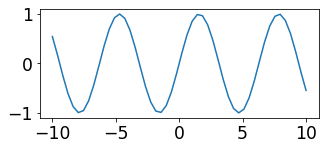

In [7]:
fig=plt.figure(figsize=(5,2))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.show()               


In [8]:
from iminuit import Minuit
import iminuit

In [9]:
iminuit.__version__

'2.8.4'

In [10]:
from astropy.io import fits
from astropy.coordinates import Angle
from astropy import units as u
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor,dumpParameters,dumpfitparameters
from spectractor.extractor.images import *
from spectractor.config import load_config, set_logger
from scipy import ndimage, misc

In [11]:
import logging

In [12]:
from scipy.stats import kurtosis,skew
from scipy.stats import kurtosistest,skewtest,normaltest

In [13]:
from distutils.dir_util import copy_tree
import shutil

# Configuration

## Logger

In [14]:
my_logger = logging

## Config for the notebook

In [15]:
version="v5.0"  # version of flipping
# create output directories if not exist and clean existing files
FLAG_MANAGE_OUTPUT_SPECTRACTOR=True
# allow to run reconstruction with Spectractor
FLAG_GO_FOR_RECONSTRUCTION_WTH_SPECTRACTOR=True
FLAG_RUNWITHEXCEPTIONS = False

## Configuration for Spectractor

In [16]:
print("List of configuration files available : ",os.listdir("config"))

List of configuration files available :  ['auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotB.ini~', '.ipynb_checkpoints', 'auxtel_config_holo_DECONVOLUTION_PSF1D.ini', 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF2D.ini', 'auxtel_config_holo_DECONVOLUTION_REBIN2FFM.ini', 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DFFM300650.ini', 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotC.ini', 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotD.ini', 'auxtel_config_ronchi_DECONVOLUTION_PSF1D.ini', 'auxtel_config_holo_DECONVOLUTION_FFM.ini', 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotA.ini', 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotD.ini~', 'auxtel_config_ronchi_DECONVOLUTION_PSF2D.ini', 'auxtel_config_holo_DECONVOLUTION_PSF2D.ini', 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotB.ini', 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotA.ini~', 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotC.ini~', 'auxtel_config_holo_DECONVOLUTION_PSF2DFFM.ini', 'auxtel_config_holo_DECONVOLUTION_REBIN2

In [17]:
# Choose the config filename
list_of_spectractorconfigfiles= ['auxtel_config_holo_DECONVOLUTION_PSF1D.ini' ,
                                 'auxtel_config_holo_DECONVOLUTION_PSF2D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_FFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_PSF2DFFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2FFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DFFM300650.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF2D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotA.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotB.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotC.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotD.ini']
config_idx = 0
                                
configfilename= os.path.join("./config",list_of_spectractorconfigfiles[config_idx])
#configdir = (list_of_spectractorconfigfiles[config_idx].split("_")[-1]).split(".") [0]
configdir = "config_" + (list_of_spectractorconfigfiles[config_idx].split("auxtel_config_holo_")[-1]).split(".") [0]

In [18]:
configfilename

'./config/auxtel_config_holo_DECONVOLUTION_PSF1D.ini'

In [19]:
configdir

'config_DECONVOLUTION_PSF1D'

In [20]:
config=configfilename
print(f">>>>> Spectractor configuration filename : {configfilename}")

>>>>> Spectractor configuration filename : ./config/auxtel_config_holo_DECONVOLUTION_PSF1D.ini


In [21]:
load_config(configfilename)

No rebinning: parameters.REBIN is forced to 1.


In [22]:
dumpParameters()

ASTROMETRYNET_DIR 
BGD_ORDER 1
CALIB_BGD_NPARAMS 4
CALIB_BGD_ORDER 3
CALIB_BGD_WIDTH 15
CALIB_PEAK_WIDTH 7
CALIB_SAVGOL_ORDER 2
CALIB_SAVGOL_WINDOW 5
CCD_ARCSEC2RADIANS 4.84813681109536e-06
CCD_GAIN 1.1
CCD_IMSIZE 4096
CCD_MAXADU 170000
CCD_PIXEL2ARCSEC 0.0952
CCD_PIXEL2MM 0.01
CCD_REBIN 1
CONFIG_DIR /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/../config/
DEBUG False
DEBUG_LOGGING False
DISPERSER_DIR /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/
DISPLAY False
DISTANCE2CCD 175
DISTANCE2CCD_ERR 0.75
FGB37 {'label': 'FGB37', 'min': 350, 'max': 750}
FILTERS [{'label': 'RG715', 'min': 690, 'max': 1100}, {'label': 'FGB37', 'min': 350, 'max': 750}, {'label': 'Halfa', 'min': 0.0006431, 'max': 0.0006686999999999999}, {'label': 'Z-Gunn', 'min': 800, 'max': 1100}]
FLAM_TO_ADURATE 5175865186660.421
GRATING_ORDER_2OVER1 0.1
GROOVES_PER_MM 350
HAL

# Exposure config

In [23]:
! ls logbooks

auxtellogbook_BG40~holo4_003_20211104_v5.0.csv
auxtellogbook_BG40~holo4_003_20211104_v5.0.xlsx
auxtellogbook_empty~holo4_003_20211104_v5.0.csv
auxtellogbook_empty~holo4_003_20211104_v5.0.xlsx
auxtellogbook_empty~holo4_003_20220316_v5.0.csv
auxtellogbook_empty~holo4_003_20220316_v5.0.xlsx
auxtellogbook_empty~holo4_003_20220317_v5.0.csv
auxtellogbook_empty~holo4_003_20220317_v5.0.xlsx
auxtellogbook_empty~ronchi170lpmm_20220316_v5.0.csv
auxtellogbook_empty~ronchi170lpmm_20220316_v5.0.xlsx
auxtellogbook_empty~ronchi170lpmm_20220317_v5.0.csv
auxtellogbook_empty~ronchi170lpmm_20220317_v5.0.xlsx
auxtellogbook_FELH0600~holo4_003_20211104_v5.0.csv
auxtellogbook_FELH0600~holo4_003_20211104_v5.0.xlsx


In [24]:
# path index for each month
DATE="20220316"
#DATE="20211104"
filterdispersername = "empty~holo4_003"
#filterdispersername = "BG40~holo4_003"
imagemode = "postISRCCD"
#imagemode = "unflattened"

In [25]:
disperser_label = filterdispersername.split("~")[-1]

## Paths

In [26]:
# select if we run at CC or not (locally) 
# /sps/lsst/groups/auxtel/data/2022/holo/20220317
HOSTCC=True
LAPTOP=False

In [27]:
# Set path depending on which computer running (according HOSTCC)
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
    if configdir == "":
        path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
    else:
        path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
        path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
        path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
        path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)

else:
    if not LAPTOP:
        path_auxtel="/Users/sylvie/DATA/AuxTelData2022"
        path_spectractor=os.path.join(path_auxtel,"/Users/sylvie/MacOSX/GitHub/LSST/Spectractor")
        path_spectractor_config=os.path.join(path_spectractor,"config")
        path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)
    else:
        path_auxtel="/Users/dagoret/DATA/AuxTelData2022"
        path_spectractor=os.path.join(path_auxtel,"/Users/dagoret/MacOSX/GitHub/LSST/Spectractor")
        path_spectractor_config=os.path.join(path_spectractor,"config")
        path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)
        


In [28]:
path_images

'/sps/lsst/groups/auxtel/data/2022/empty~holo4_003/20220316'

In [29]:
path_topoutput_spectractor

'/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1D'

In [30]:
path_output_spectractor

'/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1D/20220316'

# Utility Functions

In [31]:
def is_nan(x):
    return (x != x)

# Logbook for input file selection

- the logbook contains all input image path and possibily the order 0 position

In [32]:
!ls logbooks

auxtellogbook_BG40~holo4_003_20211104_v5.0.csv
auxtellogbook_BG40~holo4_003_20211104_v5.0.xlsx
auxtellogbook_empty~holo4_003_20211104_v5.0.csv
auxtellogbook_empty~holo4_003_20211104_v5.0.xlsx
auxtellogbook_empty~holo4_003_20220316_v5.0.csv
auxtellogbook_empty~holo4_003_20220316_v5.0.xlsx
auxtellogbook_empty~holo4_003_20220317_v5.0.csv
auxtellogbook_empty~holo4_003_20220317_v5.0.xlsx
auxtellogbook_empty~ronchi170lpmm_20220316_v5.0.csv
auxtellogbook_empty~ronchi170lpmm_20220316_v5.0.xlsx
auxtellogbook_empty~ronchi170lpmm_20220317_v5.0.csv
auxtellogbook_empty~ronchi170lpmm_20220317_v5.0.xlsx
auxtellogbook_FELH0600~holo4_003_20211104_v5.0.csv
auxtellogbook_FELH0600~holo4_003_20211104_v5.0.xlsx


In [33]:
filename_logbook='logbooks/auxtellogbook_'+filterdispersername+"_"+DATE+'_' + version+'.csv'

In [34]:
filename_logbook

'logbooks/auxtellogbook_empty~holo4_003_20220316_v5.0.csv'

In [35]:
df=pd.read_csv(filename_logbook,index_col=0)

In [36]:
pd.set_option('display.max_rows', None)

In [37]:
# show the list of input files from the logbook to select the file index in the logbook
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2022-03-17T01:59:37.776,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600330_postisrccd.fits,330,eta dor,empty_1,holo4_003,1.385409,20.0,...,10.6,44.0,7.2,NaN,NaN,NaN,NaN,,NaN,NaN
1,1,2022-03-17T02:00:10.693,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600331_postisrccd.fits,331,eta dor,empty_1,holo4_003,1.386483,20.0,...,10.6,44.0,7.4,NaN,NaN,NaN,NaN,,NaN,NaN
2,2,2022-03-17T02:03:04.275,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600337_postisrccd.fits,337,eta dor,empty_1,holo4_003,1.392269,20.0,...,10.6,43.0,7.4,NaN,NaN,NaN,NaN,,NaN,NaN
3,3,2022-03-17T02:03:37.365,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600338_postisrccd.fits,338,eta dor,empty_1,holo4_003,1.393378,20.0,...,10.6,43.0,7.4,NaN,NaN,NaN,NaN,,NaN,NaN
4,4,2022-03-17T02:06:31.026,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600344_postisrccd.fits,344,eta dor,empty_1,holo4_003,1.399309,20.0,...,10.5,43.0,8.2,NaN,NaN,NaN,NaN,,NaN,NaN
5,5,2022-03-17T02:07:03.927,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600345_postisrccd.fits,345,eta dor,empty_1,holo4_003,1.400449,20.0,...,10.5,43.0,7.6,NaN,NaN,NaN,NaN,,NaN,NaN
6,6,2022-03-17T02:11:00.681,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600351_postisrccd.fits,351,HD111980,empty_1,holo4_003,1.647734,20.0,...,10.5,43.0,13.1,300.0,1700.0,NaN,NaN,,1.0,1.0
7,7,2022-03-17T02:11:33.581,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600352_postisrccd.fits,352,HD111980,empty_1,holo4_003,1.643280,20.0,...,10.5,43.0,13.1,NaN,NaN,NaN,NaN,,NaN,NaN
8,8,2022-03-17T02:14:30.261,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600358_postisrccd.fits,358,HD111980,empty_1,holo4_003,1.619945,20.0,...,10.5,43.0,12.1,NaN,NaN,NaN,NaN,,NaN,NaN
9,9,2022-03-17T02:15:03.181,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600359_postisrccd.fits,359,HD111980,empty_1,holo4_003,1.615702,20.0,...,10.5,44.0,6.9,NaN,NaN,NaN,NaN,,NaN,NaN


# Selection of input file
- the input file is selected from the logbook list above

In [38]:
idx=1

In [39]:
print(df.iloc[idx]['file'])

exposure_2022031600331_postisrccd.fits


In [40]:
print(df.iloc[idx])

index                                                          1
date                                     2022-03-17T02:00:10.693
path           /sps/lsst/groups/auxtel/data/2022/empty~holo4_...
file                      exposure_2022031600331_postisrccd.fits
num                                                          331
object                                                   eta dor
filter                                                   empty_1
disperser                                              holo4_003
airmass                                                  1.38648
exposure                                                      20
focus                                                  0.0410588
seeing                                                  0.921627
pressure                                                  743.55
temperature                                                 10.6
humidity                                                      44
windspd                  

In [41]:
myhome=os.getenv("HOME")

In [42]:
dir_images=path_images

In [43]:
dir_images

'/sps/lsst/groups/auxtel/data/2022/empty~holo4_003/20220316'

In [44]:
filename_image=df['file'][idx]
filename_image

'exposure_2022031600331_postisrccd.fits'

In [45]:
target = df['object'][idx]
target

'eta dor'

## If order 0 position exists in logbook it is selected, otherwise put it by hand

In [46]:
# ## If order 0 position exists in logbook it is selected, otherwise put it by hand

x0=300
y0=1700

if 'Obj-posXpix' in df.columns and 'Obj-posYpix' in df.columns:
    thex0 = df['Obj-posXpix'][idx]
    if not is_nan(thex0):
        x0=thex0
    they0 = df['Obj-posYpix'][idx]
    if not is_nan(they0):
        y0=they0
    
if not is_nan(x0) and not is_nan(y0):

    print("Order 0 location from logbook : ({},{})".format(x0,y0))
else:
    print("NO Order 0 location from logbook ! ")      

print(f"guess (x0,y0) = ({x0},{y0})")


Order 0 location from logbook : (300,1700)
guess (x0,y0) = (300,1700)


## Spectractor Configuration 

- Usually the Spectractor configuration file is put in local dir **./config**


Ma suggestion, pour l'étude du centre optique via les scans des hologrammes, est de **mettre SPECTRACTOR_COMPUTE_ROTATION_ANGLE sur False** . 

Comme les angles ne sont pas très grands, si les marges du rectangle sont assez larges, réglables avec : 

    [background subtraction parameters] 
    # half transverse width of the signal rectangular window in pixels 
    PIXWIDTH_SIGNAL = 40 

alors le spectrogramme devrait tenir dans une boite rectangulaire même sans rotation de l'image. **L'important est de garder SPECTRACTOR_DECONVOLUTION_FFM à True car c'est lui qui te donnera l'angle de l'axe de dispersion ajusté sur les données, dont la valeur sera dans le mot clé ROTANGLE du header de sortie**. 


In [47]:
rootfilename = filename_image.split(".")[0]
rootfilename_split =  rootfilename.split("_") 
filenumberdir = rootfilename_split[1] 

In [48]:
path_output_spectractor

'/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1D/20220316'

In [49]:
configdir

'config_DECONVOLUTION_PSF1D'

In [50]:

# Fullfilename
filename=os.path.join(dir_images,filename_image)


# subdirectory
#subdir=filename_image.split(".")[0]
subdir=filenumberdir

# final output directory (where results will be copied to be backed up at the end)
finalpath_output_spectractor=os.path.join(path_output_spectractor,subdir)


# local directories to put spectra and plots
if configdir =="":
    output_directory="./outputs_process_holo"
    output_figures="figures_process_holo"
else:
    output_directory = "./outputs_process_" + filterdispersername + "_" + configdir
    output_figures   = "./figures_process_" + filterdispersername + "_" + configdir
    


guess = [300,1700]

# configuration

config=configfilename    
target=df.iloc[idx]["object"]

In [51]:
print(f"finalpath_output_spectractor = {finalpath_output_spectractor}")
print(f"output_directory = {output_directory}")
print(f"output_figures = {output_figures}")
print(f"config filename = {config}")

finalpath_output_spectractor = /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1D/20220316/2022031600331
output_directory = ./outputs_process_empty~holo4_003_config_DECONVOLUTION_PSF1D
output_figures = ./figures_process_empty~holo4_003_config_DECONVOLUTION_PSF1D
config filename = ./config/auxtel_config_holo_DECONVOLUTION_PSF1D.ini


In [52]:
def cleandir(path):
    if os.path.isdir(path):
        files=os.listdir(path)
        if len(files) > 0:
            for f in files:
                if os.path.isdir(os.path.join(path,f)):
                    if f==".ipynb_checkpoints":
                        shutil.rmtree(os.path.join(path,f))
                    else:
                        print(" Cannot remove this directory {}".format(os.path.join(path,f)))
                else:
                    os.remove(os.path.join(path,f))

In [53]:
if not os.path.isdir(output_directory):
    os.mkdir(output_directory)
else:
    cleandir(output_directory)
 
# manage subdirs spectrum/ and plots/
if not os.path.isdir(output_figures):
    os.mkdir(output_figures)
else:
    cleandir(output_figures)

# Configuration of the Spectractor running mode

In [54]:
parameters.LSST_SAVEFIGPATH=True
parameters.LSST_SAVEFIGPATH=output_figures

In [55]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

In [56]:
target

'eta dor'

## Load the image in the new image file with Spectractor

In [57]:
image=Image(file_name=filename, disperser_label=disperser_label, config=config)

No rebinning: parameters.REBIN is forced to 1.
target_name = etador, Selected object name for Simbad : ETA1 DOR
  MAIN_ID         RA           DEC      ...  Z_VALUE  SCRIPT_NUMBER_ID
               "h:m:s"       "d:m:s"    ...                           
----------- ------------- ------------- ... --------- ----------------
* eta01 Dor 06 06 09.3817 -66 02 22.635 ... 0.0000590                1


In [58]:
image.data.shape

(4072, 4000)

## Show relevant parameters

In [59]:
parameters.LSST_SAVEFIGPATH=True
parameters.LSST_SAVEFIGPATH=output_figures

In [60]:
image.header["FILTER"]

'empty_1'

In [61]:
image.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
ORIGIN  = 'LSST DM Header Service'                                              
TIMESYS = 'TAI     '                                                            
DATE    = '2022-03-17T01:59:56.544'                                             
DATE-OBS= '2022-03-17T01:59:56.544'                                             
DATE-BEG= '2022-03-17T02:00:10.693'                                             
DATE-END= '2022-03-17T02:00:30.923'                                             
MJD     =     59655.0832933353                                                  
MJD-OBS =     59655.0834570961                                                  
MJD-BEG =     59655.08345709

# Plot image and find the target position

- this image plotting is used to find the order 0 location to be set in logbook

- for the moment this is humanly done

## Load the new image file with Spectractor

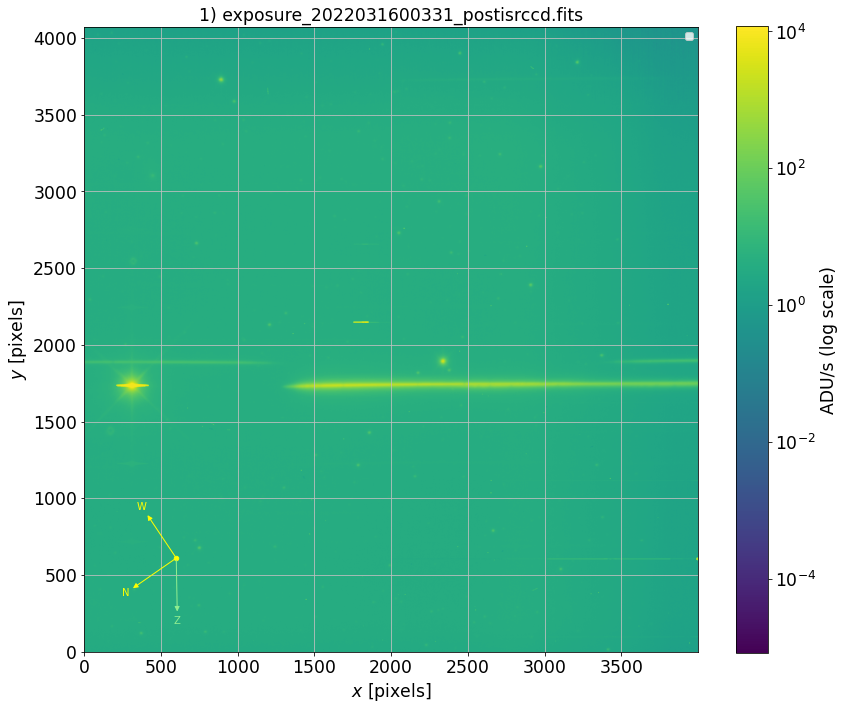

In [62]:
title="{}) {}".format(idx,filename_image)
image.plot_image(figsize=(12, 10),scale="log",title=title)

- note now the position are written in the make_logbook.ipynb notebook

## Set the 0th order location to be provided to Spectractor

In [63]:
filename_image

'exposure_2022031600331_postisrccd.fits'

## Let Spectractor find the location of the 0th order

2022-09-12 13:07:39  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0               c1_0                c0_1       
    ----------------- ------------------- -------------------
    6.798547405049264 0.05048619956994296 0.10936732041201444
2022-09-12 13:07:40  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 18 iterations because the relative change of cost is below ftol=1.25e-05.
2022-09-12 13:07:40  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 2 iterations because the relative change of cost is below ftol=5e-05.


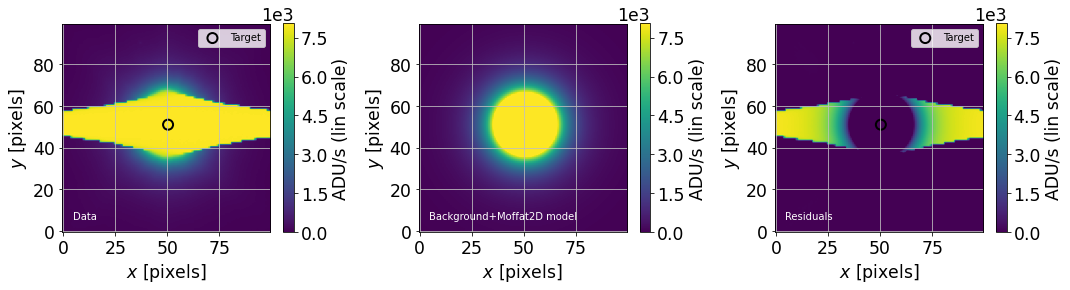

In [64]:

parameters.VERBOSE = True
parameters.DEBUG = True
#x1, y1 = find_target(image, guess,rotated=False, use_wcs=False)
x1, y1 = find_target(image, guess,rotated=False)

In [65]:
print(x1,y1)

312.36555140518436 1735.9727532955699


## Check the location of 0th order and Analysis of the quality of its focus

In [66]:
if x1>100:
    WID=100
else:
    WID=50
    

thumbnail=np.copy(image.data[int(y1)-WID:int(y1)+WID,int(x1)-WID:int(x1)+WID])
thumbnail_y=thumbnail.sum(axis=1)
thumbnail_x=thumbnail.sum(axis=0)
xx=np.linspace(int(x1)-WID,int(x1)+WID,len(thumbnail_x))
yy=np.linspace(int(y1)-WID,int(y1)+WID,len(thumbnail_y))
k0=kurtosis(thumbnail,axis=None,bias=True,fisher=True)
kx=kurtosis(thumbnail_x,bias=True,fisher=True)
ky=kurtosis(thumbnail_y,bias=True,fisher=True)
s0=skew(thumbnail,axis=None,bias=True)
sx=skew(thumbnail_x,bias=True)
sy=skew(thumbnail_y,bias=True)
        

In [67]:
shape_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}, Skx = {:3.3f}, Sky = {:3.3f} \n'.format(s0,sx,sy),
        r'kurtosis : K0  = {:3.3f}, Kx  = {:3.3f},  Ky = {:3.3f}'.format(k0,kx,ky)))

In [68]:
skew_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}'.format(s0),
        r'             : Skx = {:3.3f}'.format(sx),
        r'             : Sky = {:3.3f}'.format(sy)))

In [69]:
kurt_str='\n'.join((
        r'kurtosis : K0 = {:3.3f}'.format(k0),
        r'             : Kx = {:3.3f}'.format(kx),
        r'             : Ky = {:3.3f}'.format(ky)))

In [70]:
kurtosis_test_prob=kurtosistest(thumbnail,axis=None).pvalue
skew_test_prob=skewtest(thumbnail,axis=None).pvalue
normal_test_prob=normaltest(thumbnail,axis=None).pvalue

In [71]:
kurtosis_test_val=kurtosistest(thumbnail,axis=None).statistic
skew_test_val=skewtest(thumbnail,axis=None).statistic
normal_test_val=normaltest(thumbnail,axis=None).statistic

In [72]:
kurtosis_test_prob_x=kurtosistest(thumbnail_x).pvalue
skew_test_prob_x=skewtest(thumbnail_x).pvalue
normal_test_prob_x=normaltest(thumbnail_x).pvalue

In [73]:
kurtosis_test_prob_y=kurtosistest(thumbnail_y).pvalue
skew_test_prob_y=skewtest(thumbnail_y).pvalue
normal_test_prob_y=normaltest(thumbnail_y).pvalue

In [74]:
skew_str='\n'.join((
    r'skew     : Sk0 = {:3.3f}'.format(s0),
    r'             : Skx = {:3.3f}'.format(sx),
    r'             : Sky = {:3.3f}'.format(sy),
    r'             : p_test   = {:3.3e}'.format(skew_test_prob),
    r'             : p_test_x = {:3.3e}'.format(skew_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(skew_test_prob_y)))

In [75]:
kurt_str='\n'.join((
    r'kurtosis : K0 = {:3.3f}'.format(k0),
    r'             : Kx = {:3.3f}'.format(kx),
    r'             : Ky = {:3.3f}'.format(ky),
    r'             : p_test   = {:3.3e}'.format(kurtosis_test_prob),
    r'             : p_test_x = {:3.3e}'.format(kurtosis_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(kurtosis_test_prob_y)))

In [76]:
norm_str='\n'.join((
    r'normal  : p_test   = {:3.3e}'.format(normal_test_prob),
    r'             : p_test_x = {:3.3e}'.format(normal_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(normal_test_prob_y)))

In [77]:
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [78]:
#matplotlib.pyplot.hist(x, 
#                       bins=10, 
#                       range=None, 
#                       normed=False, 
#                       weights=None, 
#                       cumulative=False, 
#                       bottom=None, 
#                       histtype=u'bar', 
#                       align=u'mid', 
#                       orientation=u'vertical', 
#                       rwidth=None, 
#                       log=False, 
#                       color=None, 
#                       label=None, 
#                       stacked=False, 
#                       hold=None, 
#                       **kwargs)

Text(0.5, 0.98, '1) exposure_2022031600331_postisrccd.fits')

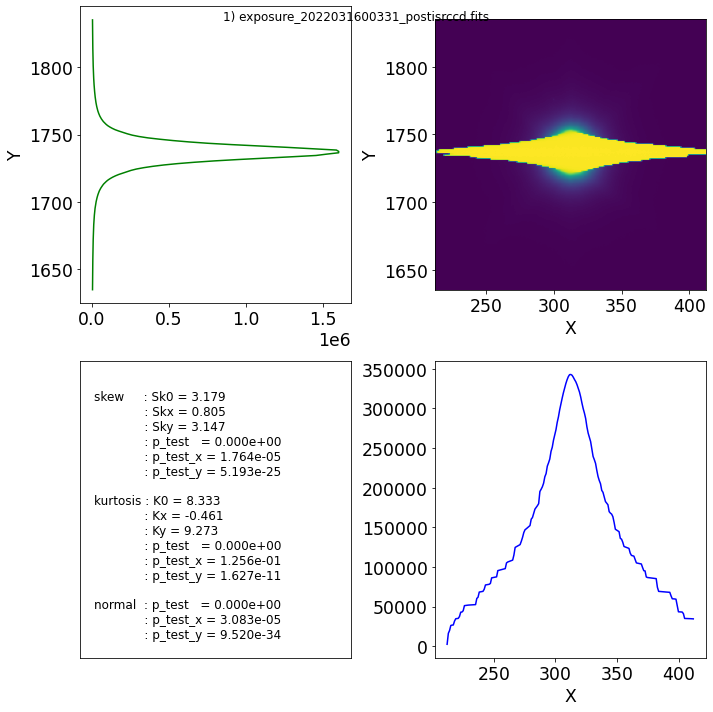

In [79]:
fig=plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0.12, right=0.95, wspace=0.3,
                    bottom=0.15, top=0.9)

ax=fig.add_subplot(222)
ax.imshow(thumbnail,origin="lower",extent=(int(x1)-WID,int(x1)+WID,int(y1)-WID,int(y1)+WID))
ax.set_xlabel("X")
ax.set_ylabel("Y")

ax=fig.add_subplot(221)
base = plt.gca().transData
rot = transforms.Affine2D().rotate_deg(-90)
#ax.plot(yy,thumbnail_y,"g",rotation=u'vertical')
ax.plot(-yy,thumbnail_y,"g",transform= rot + base)
ax.set_ylabel("Y")

ax=fig.add_subplot(224)
ax.plot(xx,thumbnail_x,"b")
ax.set_xlabel("X")
plt.tight_layout()

ax=fig.add_subplot(223)
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.text(0.05, 0.9, skew_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.55, kurt_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.2, norm_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
plt.suptitle(title)

In [80]:
# Usually stop here if one just want to get the 0th order location
if not FLAG_GO_FOR_RECONSTRUCTION_WTH_SPECTRACTOR:
    assert False
else:
    assert True

# Go for spectrum reconstruction

In [81]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

parameters.DEBUG=True
parameters.VERBOSE=True
parameters.DISPLAY=True
parameters.LIVE_FIT=False

In [82]:
filename

'/sps/lsst/groups/auxtel/data/2022/empty~holo4_003/20220316/exposure_2022031600331_postisrccd.fits'

In [83]:
output_directory

'./outputs_process_empty~holo4_003_config_DECONVOLUTION_PSF1D'

2022-09-12 13:07:43  spectractor.extractor.extractor Spectractor          INFO   
	Start SPECTRACTOR
2022-09-12 13:07:43  Image      load_AUXTEL_image    INFO   
	Loading AUXTEL image /sps/lsst/groups/auxtel/data/2022/empty~holo4_003/20220316/exposure_2022031600331_postisrccd.fits...
2022-09-12 13:07:43  Image      load_AUXTEL_image    INFO   
	Image loaded
2022-09-12 13:07:43  Image      load_image           INFO   
	Loading disperser holo4_003...
2022-09-12 13:07:43  Hologram   load_specs           INFO   
	Load disperser holo4_003:
	from /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/holo4_003
2022-09-12 13:07:43  Hologram   load_specs           INFO   
	Grating characteristics:
	N = 156.00 +/- 1.00 grooves/mm
	Average tilt of -0.3 degrees


No rebinning: parameters.REBIN is forced to 1.
Section: paths
x disperser_dir: extractor/dispersers/	=> parameters.DISPERSER_DIR: /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/	 <class 'str'>
x throughput_dir: simulation/AuxTelThroughput/	=> parameters.THROUGHPUT_DIR: /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/simulation/AuxTelThroughput/	 <class 'str'>
Section: pipeline
x spectractor_fit_target_centroid: fit	=> parameters.SPECTRACTOR_FIT_TARGET_CENTROID: fit	 <class 'str'>
x spectractor_compute_rotation_angle: disperser	=> parameters.SPECTRACTOR_COMPUTE_ROTATION_ANGLE: disperser	 <class 'str'>
x spectractor_deconvolution_psf2d: False	=> parameters.SPECTRACTOR_DECONVOLUTION_PSF2D: False	 <class 'bool'>
x spectractor_deconvolution_ffm: False	=> parameters.SPECTRACTOR_DECONVOLUTION_FFM: False	 <class 'bool'>
x spectractor_deconvolutio

2022-09-12 13:07:45  Star       load                 INFO   
	Simbad:
  MAIN_ID         RA           DEC      ... Z_VALUE_2 SCRIPT_NUMBER_ID
               "h:m:s"       "d:m:s"    ...                           
----------- ------------- ------------- ... --------- ----------------
* eta01 Dor 06 06 09.3817 -66 02 22.635 ... 0.0000590                1
2022-09-12 13:07:46  Star       load_spectra         INFO   
	Loading /sps/lsst/groups/auxtel/softs/utils/PySynPhotData/grp/hst/cdbs//calspec/eta1dor_stis_002.fits


target_name = etador, Selected object name for Simbad : ETA1 DOR
  MAIN_ID         RA           DEC      ... Z_VALUE_2 SCRIPT_NUMBER_ID
               "h:m:s"       "d:m:s"    ...                           
----------- ------------- ------------- ... --------- ----------------
* eta01 Dor 06 06 09.3817 -66 02 22.635 ... 0.0000590                1


2022-09-12 13:07:47  spectractor.extractor.extractor Spectractor          INFO   
	Search for the target in the image with guess=[ 312.36555141 1735.9727533 ]...
2022-09-12 13:07:47  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                 c1_0                  c0_1        
    ------------------ --------------------- ---------------------
    23.567952202594043 0.0022125041100363252 -0.006931150475476118
2022-09-12 13:07:49  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 17 iterations because the relative change of cost is below ftol=1.25e-05.
2022-09-12 13:07:50  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 3 iterations because the relative change of cost is below ftol=5e-05.
2022-09-12 13:07:50  Image      find_target          INFO   
	X,Y target position in pixels: 312.379,1735.997
202

	 >>>>> cov =  [[ 6.67000356e-08 -4.11579251e-08  2.04095089e-08  1.72393440e-08
  -3.04766206e-09 -1.65497097e-07 -1.41208183e-08  2.35274640e-08
  -1.18777911e-07]
 [-4.11579251e-08  3.00715983e-07 -2.71505087e-07  4.81730688e-08
  -3.08177536e-08 -3.45953541e-07  3.01631886e-08 -6.53174907e-08
  -8.88764463e-08]
 [ 2.04095089e-08 -2.71505087e-07  6.19697837e-07 -6.59872271e-08
  -1.55030836e-08  5.58752191e-07 -3.52288132e-08  5.47562604e-08
   3.07494669e-07]
 [ 1.72393440e-08  4.81730688e-08 -6.59872271e-08  5.33552345e-05
  -6.98636575e-05 -4.74891058e-05  1.10496196e-05 -1.19748560e-05
   9.66672001e-06]
 [-3.04766206e-09 -3.08177536e-08 -1.55030836e-08 -6.98636575e-05
   1.24654262e-04 -2.30055608e-05 -1.75651601e-05  2.96092485e-05
  -5.46788928e-05]
 [-1.65497097e-07 -3.45953541e-07  5.58752191e-07 -4.74891058e-05
  -2.30055608e-05  5.39137692e-04  6.55895530e-06 -4.49149339e-05
   1.84084181e-04]
 [-1.41208183e-08  3.01631886e-08 -3.52288132e-08  1.10496196e-05
  -1.75651601

2022-09-12 13:09:46  ChromaticPSF1DFitWorkspace plot_correlation_matrix INFO   Save figure ./figures_process_empty~holo4_003_config_DECONVOLUTION_PSF1D/parameters_correlation.pdf.
2022-09-12 13:09:53  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop raw image [1160:3464,1540:1912] (size (2304, 372))
2022-09-12 13:09:53  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	  ======================= Extract the non rotated background  =============================
2022-09-12 13:09:56  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Background statistics: mean=4.370 ADU/s, RMS=0.637 ADU/s.
2022-09-12 13:09:56  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	  ======================= first guess for lambdas  =============================
2022-09-12 13:09:56  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop image [1160:3464,1540:1912] (size (2

Set header key DATE-OBS to 2022-03-17T01:59:56.544 from attr date_obs
Set header key EXPTIME to 20.0 from attr expo
Set header key AIRMASS to 1.386860919079735 from attr airmass
Set header key GRATING to holo4_003 from attr disperser_label
Set header key UNIT2 to erg/s/cm$^2$/nm from attr units
Set header key ROTANGLE to -0.28 from attr rotation_angle
Set header key DEC to -66.0397222222222 from attr dec
Set header key HA to 42.196644128114244 from attr hour_angle
Set header key OUTTEMP to 10.6 from attr temperature
Set header key OUTPRESS to 743.55 from attr pressure
Set header key OUTHUM to 44.0 from attr humidity
Set header key LBDA_REF to 622.5789704842468 from attr lambda_ref
Set header key PARANGLE to 56.75888867802155 from attr parallactic_angle


2022-09-12 13:10:39  Spectrum   save_spectrum        INFO   
	Spectrum saved in ./outputs_process_empty~holo4_003_config_DECONVOLUTION_PSF1D/exposure_2022031600331_postisrccd_spectrum.fits
2022-09-12 13:10:40  Spectrum   save_spectrogram     INFO   
	Spectrogram saved in ./outputs_process_empty~holo4_003_config_DECONVOLUTION_PSF1D/exposure_2022031600331_postisrccd_spectrogram.fits
2022-09-12 13:10:40  astropy    _showwarning         WARNING UnitsWarning: 'erg/s/cm$^2$/nm' did not parse as fits unit: Invalid character at col 8 If this is meant to be a custom unit, define it with 'u.def_unit'. To have it recognized inside a file reader or other code, enable it with 'u.add_enabled_units'. For details, see https://docs.astropy.org/en/latest/units/combining_and_defining.html
2022-09-12 13:10:40  astropy    _showwarning         WARNING UnitsWarning: 'reduced' did not parse as fits unit: At col 0, Unit 'reduced' not supported by the FITS standard.  If this is meant to be a custom unit, define

    Line    Tabulated  Detected ...   Chisq   Eqwidth_mod Eqwidth_data
                nm        nm    ...  reduced       nm          nm     
----------- --------- --------- ... --------- ----------- ------------
  $Ca_{II}$ 393.38922 389.19724 ...  26.98245     6.02551    24.499432
  $Ca_{II}$ 396.87042  396.2519 ...  26.98245    1.388096     8.918635
$H\epsilon$ 397.02344 400.27835 ...  26.98245   1.2696935      9.74268
  $H\delta$  410.2242 409.50568 ...  26.98245   4.2763276     13.02448
   $Fe_{I}$ 430.81543 422.89502 ...  26.98245   2.0862443    11.875291
  $H\gamma$  434.0256  433.5781 ...  26.98245   1.2019503     3.610237
   $Fe_{I}$ 438.38086 436.36844 ...  26.98245   0.9595736     5.351256
   $He_{I}$ 447.12637 460.93484 ...  26.98245  0.11521454    0.7696511
   $H\beta$  486.3287 486.03458 ...  8.955997   1.4451158    1.4423579
   $Mg_{I}$ 518.39056  517.8456 ... 1.6747358 0.022458155   0.06400682
   $Fe_{I}$ 527.07007  529.0393 ... 1.6747358  0.05511803   0.11550568
  $H\a

2022-09-12 13:10:40  astropy    _showwarning         WARNING UnitsWarning: 'reduced' did not parse as fits unit: At col 0, Unit 'reduced' not supported by the FITS standard.  If this is meant to be a custom unit, define it with 'u.def_unit'. To have it recognized inside a file reader or other code, enable it with 'u.add_enabled_units'. For details, see https://docs.astropy.org/en/latest/units/combining_and_defining.html


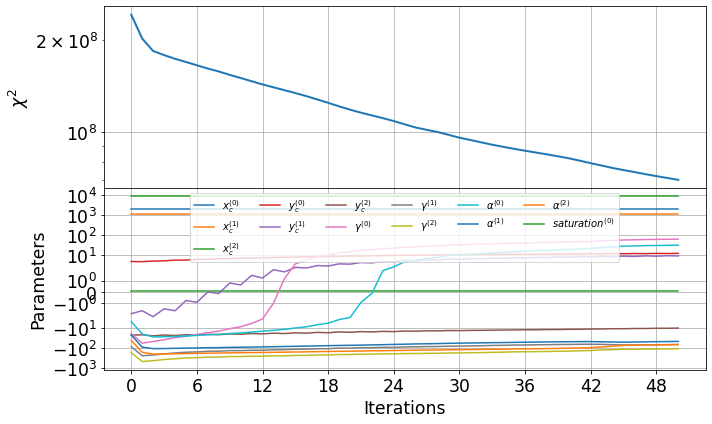

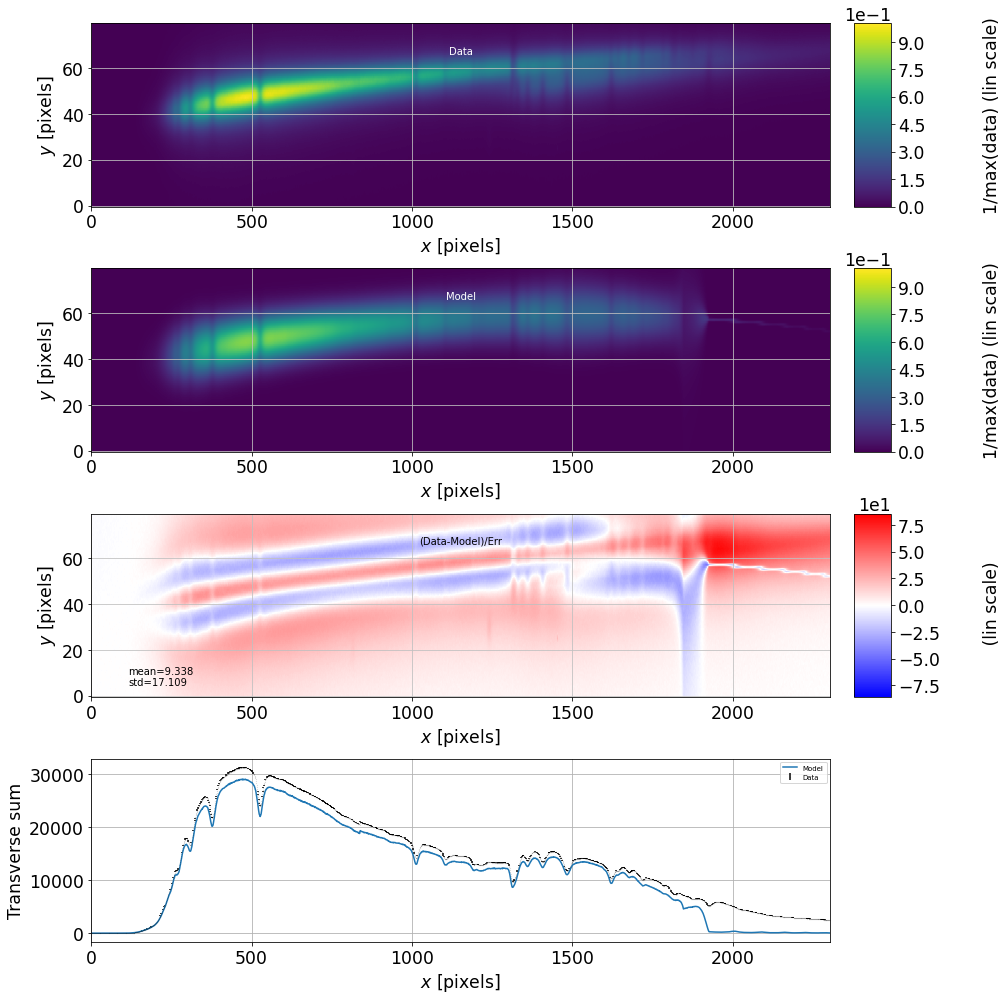

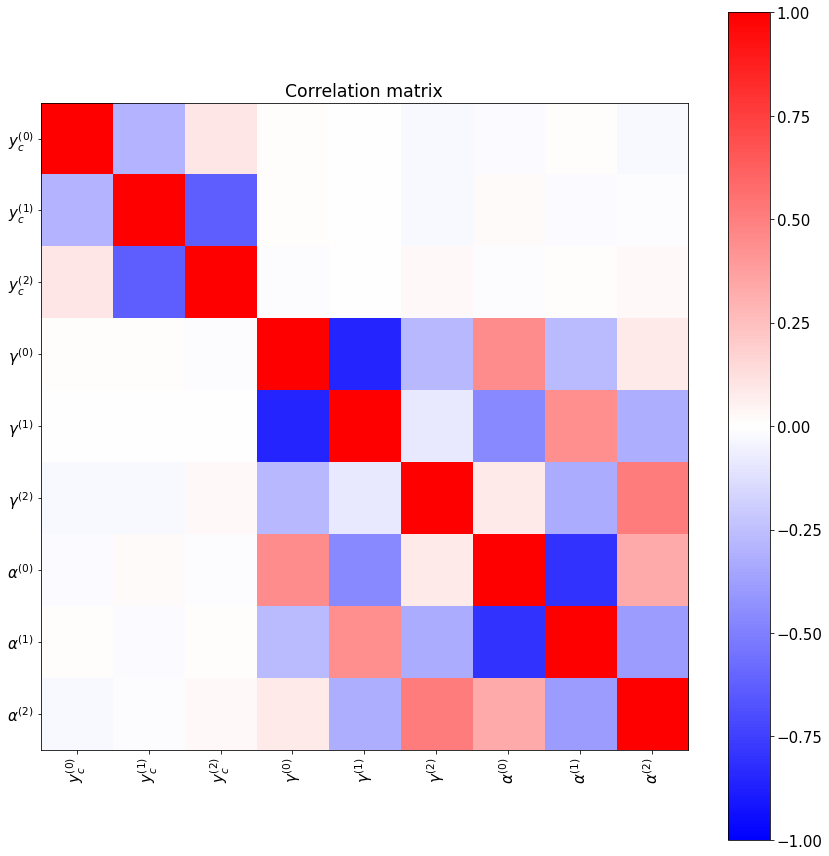

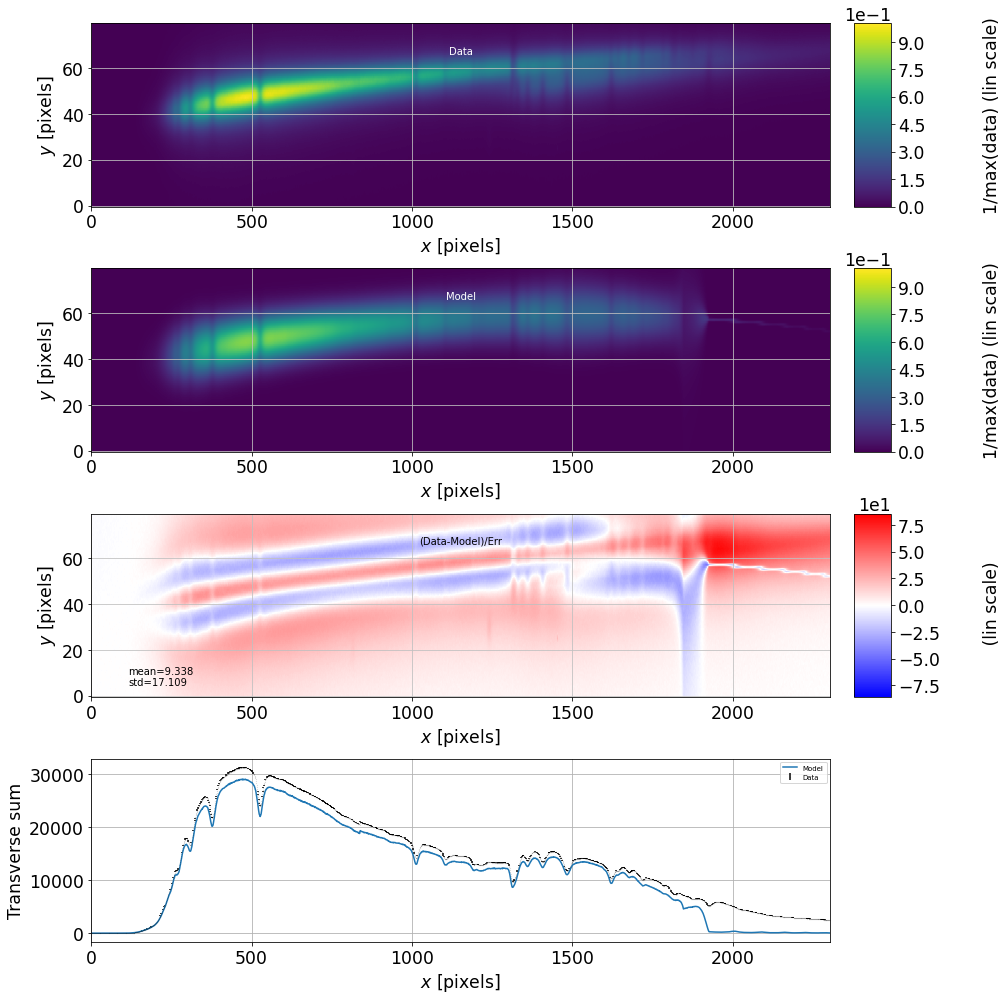

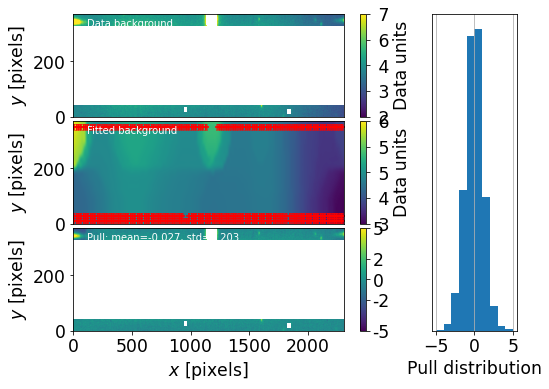

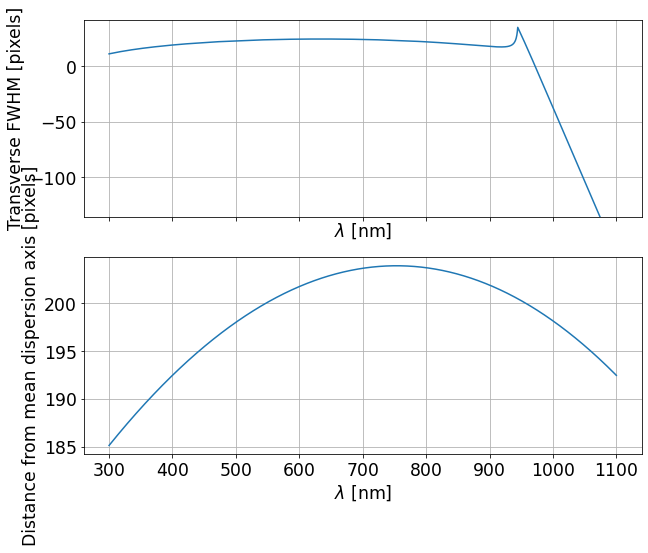

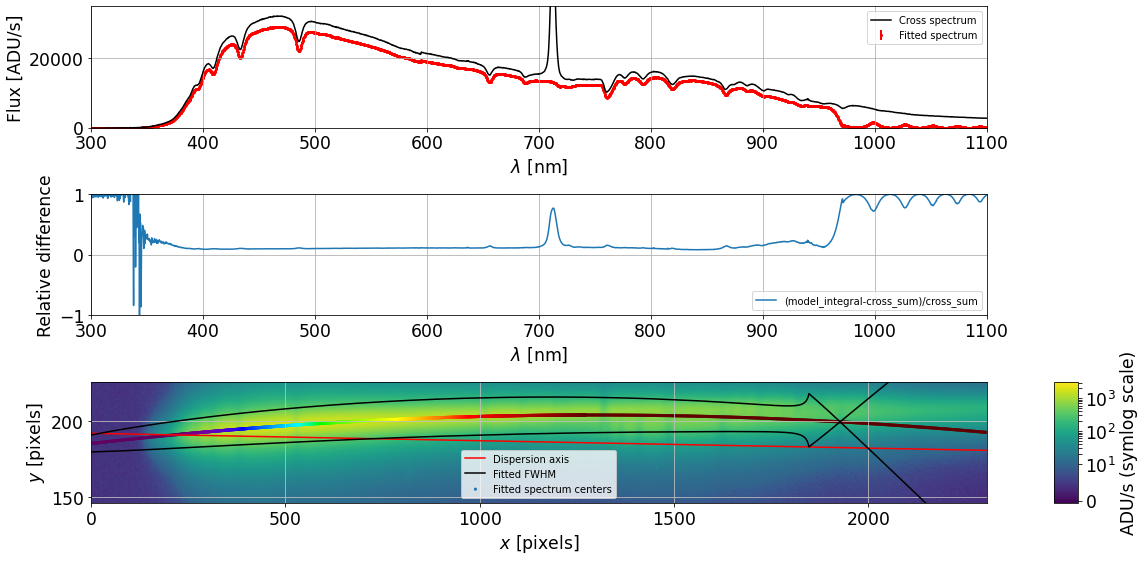

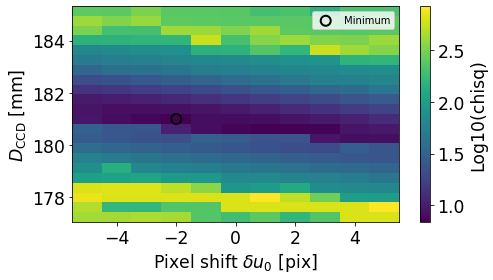

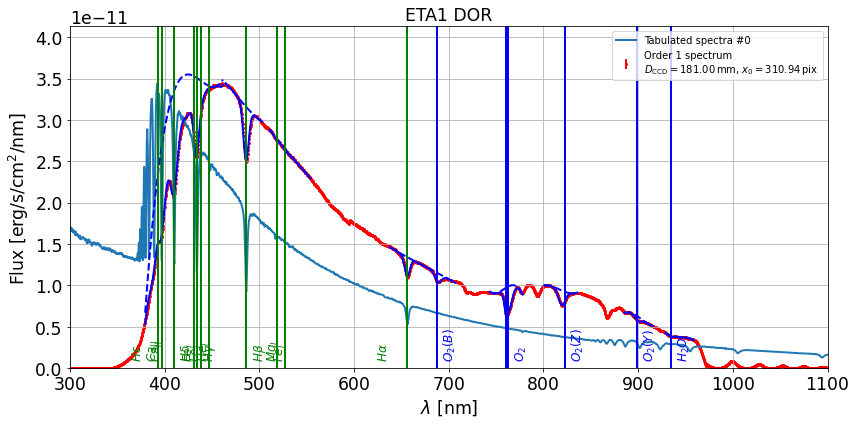

In [84]:
if FLAG_RUNWITHEXCEPTIONS:
    try:
        spectrum = Spectractor(filename, output_directory, guess=[x1,y1], target_label=target, disperser_label=disperser_label, config=config)
    except:
        errtype = sys.exc_info()[0]  # E.g. <class 'PermissionError'>
        description = sys.exc_info()[1]   # E.g. [Errno 13] Permission denied: ...
        
        print("\t +++++++++++++++++++++ Exception occured +++++++++++++++++++++++++++++++++++++++++")
        print(f"\t >>>>>  errtype = {errtype}")
        print(f"\t >>>>>> description = {description}")
else:
    spectrum = Spectractor(filename, output_directory, guess=[x1,y1], target_label=target, disperser_label=disperser_label, config=config)

    Line    Tabulated  Detected ...   Chisq   Eqwidth_mod Eqwidth_data
                nm        nm    ...  reduced       nm          nm     
----------- --------- --------- ... --------- ----------- ------------
  $Ca_{II}$ 393.38922 389.19724 ...  26.98245     6.02551    24.499432
  $Ca_{II}$ 396.87042  396.2519 ...  26.98245    1.388096     8.918635
$H\epsilon$ 397.02344 400.27835 ...  26.98245   1.2696935      9.74268
  $H\delta$  410.2242 409.50568 ...  26.98245   4.2763276     13.02448
   $Fe_{I}$ 430.81543 422.89502 ...  26.98245   2.0862443    11.875291
  $H\gamma$  434.0256  433.5781 ...  26.98245   1.2019503     3.610237
   $Fe_{I}$ 438.38086 436.36844 ...  26.98245   0.9595736     5.351256
   $He_{I}$ 447.12637 460.93484 ...  26.98245  0.11521454    0.7696511
   $H\beta$  486.3287 486.03458 ...  8.955997   1.4451158    1.4423579
   $Mg_{I}$ 518.39056  517.8456 ... 1.6747358 0.022458155   0.06400682
   $Fe_{I}$ 527.07007  529.0393 ... 1.6747358  0.05511803   0.11550568
  $H\a

2022-09-12 13:10:48  astropy    _showwarning         WARNING UnitsWarning: 'reduced' did not parse as fits unit: At col 0, Unit 'reduced' not supported by the FITS standard.  If this is meant to be a custom unit, define it with 'u.def_unit'. To have it recognized inside a file reader or other code, enable it with 'u.add_enabled_units'. For details, see https://docs.astropy.org/en/latest/units/combining_and_defining.html


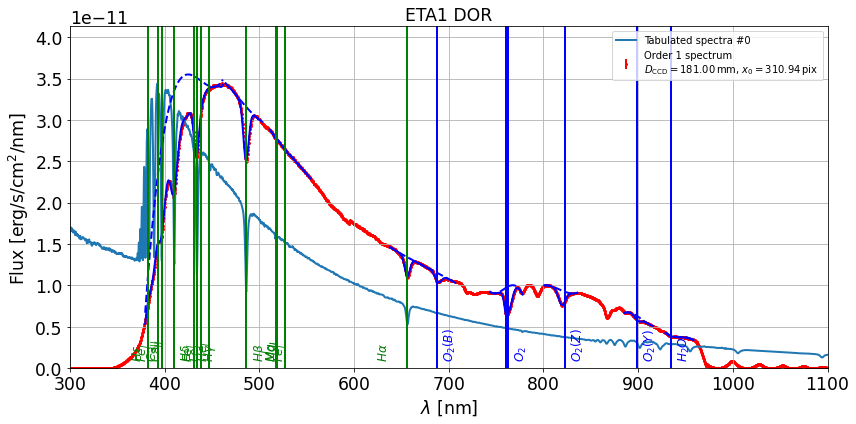

In [85]:
spectrum.plot_spectrum(force_lines=True) 

# Backup output

- If no crash occurs, arrive here

./outputs_process_holo_config_DECONVOLUTION_PSF2D

In [86]:
def cleandir(path):
    if os.path.isdir(path):
        files=os.listdir(path)
        if len(files) > 0:
            for f in files:
                if os.path.isdir(os.path.join(path,f)):
                    if f==".ipynb_checkpoints":
                        shutil.rmtree(os.path.join(path,f))
                    else:
                        print(" Cannot remove this directory {}".format(os.path.join(path,f)))
                else:
                    os.remove(os.path.join(path,f))

In [87]:
# this flag must be set if one want to clean results from previous runs
if FLAG_MANAGE_OUTPUT_SPECTRACTOR:
    
    # manage global output directory of spectractor
    # Basically it has the name of the input file image
    
    if not os.path.isdir(path_toptoptopoutput_spectractor):
        os.mkdir(path_toptoptopoutput_spectractor)
    
    if not os.path.isdir(path_toptopoutput_spectractor):
        os.mkdir(path_toptopoutput_spectractor) 
        
    if configdir !="":
    # top directory    
        if not os.path.isdir(path_topoutput_spectractor):
            os.mkdir(path_topoutput_spectractor)   
            
            
        if not os.path.isdir(path_output_spectractor):
            os.mkdir(path_output_spectractor)
  
    
    if not os.path.isdir(finalpath_output_spectractor):
        os.mkdir(finalpath_output_spectractor)
        os.mkdir(os.path.join(finalpath_output_spectractor,"basespec"))
        os.mkdir(os.path.join(finalpath_output_spectractor,"plots"))
    else:
        cleandir(os.path.join(finalpath_output_spectractor,"basespec"))
        cleandir(os.path.join(finalpath_output_spectractor,"plots"))

In [88]:
print("******************************** SUCCESS ********************************************")

******************************** SUCCESS ********************************************


In [89]:
copy_tree(output_directory,os.path.join(finalpath_output_spectractor,"basespec"))

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1D/20220316/2022031600331/basespec/exposure_2022031600331_postisrccd_spectrum.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1D/20220316/2022031600331/basespec/exposure_2022031600331_postisrccd_spectrogram.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1D/20220316/2022031600331/basespec/exposure_2022031600331_postisrccd_lines.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1D/20220316/2022031600331/basespec/exposure_2022031600331_postisrccd_table.csv']

In [90]:
copy_tree(output_figures,os.path.join(finalpath_output_spectractor,"plots"))

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1D/20220316/2022031600331/plots/background_extraction.pdf',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1D/20220316/2022031600331/plots/ETA1 DOR_spectrum.pdf',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1D/20220316/2022031600331/plots/extractedLines.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1D/20220316/2022031600331/plots/D2CCD_x0_fit.pdf',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1D/20220316/2022031600331/plots/intermediate_spectrum.pdf',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1D/20220316/2022031600331/plots/image.pdf',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpe

In [91]:
print("finalpath_output_spectractor = ",finalpath_output_spectractor)

finalpath_output_spectractor =  /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF1D/20220316/2022031600331


In [92]:
os.listdir(os.path.join(finalpath_output_spectractor,"basespec"))

['exposure_2022031600331_postisrccd_spectrum.fits',
 'exposure_2022031600331_postisrccd_table.csv',
 'exposure_2022031600331_postisrccd_spectrogram.fits',
 'exposure_2022031600331_postisrccd_lines.csv']

In [93]:
os.listdir(os.path.join(finalpath_output_spectractor,"plots"))

['D2CCD_x0_fit.pdf',
 'rotated_image.pdf',
 'order0_centroid_fit.pdf',
 'fit_chromatic_psf_best_fit_noprior.pdf',
 'sub_image_subtracted.pdf',
 'extractedLines.fits',
 'image.pdf',
 'fwhm.pdf',
 'intermediate_spectrum.pdf',
 'background_extraction.pdf',
 'parameters_correlation.pdf',
 'ETA1 DOR_spectrum.pdf']

In [94]:
output_directory

'./outputs_process_empty~holo4_003_config_DECONVOLUTION_PSF1D'